# 3. Word Embeddings & Poetry
This section is intended to serve as an introduction to many of the things that we will touch on in my NLP section pertaining to Deep learning applied to natural language processing.

You will notice that a lot of the RNN examples that we go over, as well as elsewhere on the web will use word sequences as examples. Why is that?

1. Language is an easy topic to comprehend! We speak, read, and write every single day, which makes it rather intuitive to deal with. If you are reading this post, then you are unavoidably using those abilities at this very moment.
2. RNN's allow for us to no longer treat sentences as **bag-of-words**.

Let's focus on number 2 above for a moment. As an example, consider the sentence:

> "Dogs love cats and I"

It _almost_ has the correct gramatical structure, but its meaning is most certainly different from the original sentence:

> "I love dogs and cats"

So, there is a lot of information (in the quantitative sense) that is thrown away when you use bag-of-words. At this point I am assuming that you have gone through my posts concerning Logistic Regression and intro to NLP, which both go over sentiment analysis and utilize bag-of-words. But in case you have not, let me define bag of words quickly.

## 1. Bag-of-Words
Consider a the task of sentiment analysis, where we are trying to determine whether a sentence is positive or negative. A positive sentence may be:

> "Wow, today is a great day!"

While a negative sentence may be:

> "Ugh, this movie is absolutely terrible."

In order to turn each sentence into an input for the classifier, we first start with a vector of 0's of size $V$ (our vocabularly size), so there is an entry for every individual word:

```
X=[0,0,0,...,0]
len(X) = V
```

We keep track of which word goes with which index using a dictionary, `word2idx`. Now, for every word in the sentence, we will set the corresponding index in the vector to `1`, or perhaps some other frequency measure:

```
X[idx_of_word] = 1
```

So, there is a nonzero value for every word that appears in the sentence, and everywhere else zero:

```
X = [0,1,0,0,...,1]
```

You can see how given this vector, it wouldn't be easy to determine the correct order of words in the sentence. It isn't completely impossible, if for instance the words are such that their is only one possible ordering, but generally some information is lost. 

Now, what happens when you have the two similar sentences:

> "Today is a good day."

And:

> "Today is _not_ a good day."

Well, these lead to nearly the exact same input vector, except `X[not] = 1`. This is actually a known drawback of bag-of-words; they are notoriously bad at being able to handle negation. Now, given what we know about RNN's, you can imagine that they may be good at this because they keep state! For instance, if the RNN saw the word _not_, it may negate everything that comes after it. 

## 2. Word Embeddings
This brings us to a paramount question: How _do_ we treat words in deep learning? The popular method at the moment, which has been able to produce very impressive results, is the use of word embeddings or word vectors. That means that given a vocabulary size $V$, we choose a dimensionality that is much smaller than that, $D$, where $D << V$, and then map each word vector to somewhere in the $D$ dimensional space. By training a model to do certain things like trying to predict the next word, or try to predict surrounding words, we get vectors (word embeddings) that can be manipulated via arithmetic to produce analogies such as:


> king - man $\approx$ queen - woman

The question now is how do we use word embeddings with Recurrent Neural Networks? To accomplish this, we simply create an embedding layer in the RNN. So, the input simply arrives as a one hot encoded word, and in the next layer it becomes a $D$ dimensional vector.

<img src="https://drive.google.com/uc?id=1Q2eh1IRL0qxB05p-xb4TJvYSwEHZP7HO" width="500">

This requires the word embedding transformation matrix to be a $VxD$ matrix, where the $i$th row is the word vector for the $i$th word. For reference, all of the matrix dimensions are below:

$$W_e = VxD$$

$$W_x = DxM$$

$$W_h = MxM$$

$$W_o = MxK$$

Two questions will naturally arise at this point. The first being:

1. How do we traing this model?

The answer to this is our old friend, gradient descent. We will also see later that when we do Word2Vec that there are some variations on the cross entropy error function that will help us speed up training. The second question is:

2. What are the targets? 

This is a good question because language models don't necessarily have targets. You can attempt to learn word embeddings on a sentiment analysis task, so your targets could be movie ratings or some kind of movie score. Your targets could also be next word prediction as we discussed before. Again, if we use Word2Vec, the targets will also change based on the particular Word2Vec method we use. 

## 3. Word Analogies with Word Embeddings
We are now going to go over how you actually can perform calculations that show that:

> king - man $\approx$ queen - woman

It is quite simple, but worth going through so that intuitions can start forming about this entire process.

We can start be rewriting the above as:

> king - man + woman = ?

Then there are two main steps:

1. Convert 3 words on the left to their word embeddings. For example: 

```
vec(king) = Word_embedding[word2idx["king"]]
v0 = vec(king) - vec(man) + vec(woman)
```

And `v0` is just a vector in space with an infinte number of values!

2. We want to then find the "closest" actual word in our vocabulary to the `v0`, and return that word.

Why do we need to do that? Well, the result of `vec(king) - vec(man) + vec(woman)` just gives us a vector. There is no way to map from vectors to words, since a vector space is continuous, and that would require and infinite number of words. So, the idea is that we just find closest word. 

### 3.1 Distance
There are various ways of defining distance in the context above. Sometimes, we will simply use _Euclidean Distance_:

$$\text{Euclidean Distance: } ||a - b||^2$$

It is also common to use the _cosine distance_:

$$\text{Cosine Distance: } cosine\_distance(a, b) = \frac{1 - a^Tb}{||a|| \; ||b||}$$

In this later form, since only the angle matters, because:

$$a^Tb = ||a|| \; ||b|| cos(a,b)$$ 

During training we normalize all of the word vectors so that their length is 1:

$$cos(0) = 1, \; cos(90) = 0, \; cos(180) = -1$$

When two vectors are closer, $cos(\theta)$ is bigger. So, we want our distance to be:

$$\text{Distance} = 1 - cos(\theta)$$

At this point we can say that all of the word embeddings lie on the unit sphere. 

### 3.2 Find the best word
Once we have our distance function, how do we actually find the closest word? The simplest word is to just look at every word in the vocabulary, and get the distance between each vector and your expression vector. Keep track of the smallest distance and then return that word. 

```
min_dist = Infinity; best_word = ''
for word, idx in word2idx.items():
    v1 = Word_embedding[idx]
    if dist(v0, v1) < min_dist:
        min_dist = dist(v0, v1)
        best_word = word

print("The best word is: ", best_word)
```

We may want to leave out the words from the left side of the equation, in this case _king, man_, and _woman_. Note that we will not be using this on our upcoming poetry data, since it doesn't have the kind of vocabulary we are looking for. We are more interested in things like nouns when we do word analogies. We want to compare kings and queens, men and women, occupations, etc. We will look more at word analogies later on. 

## 4. Representing a Sequence of Words as a Sequence of Word Embeddings
Let's quickly go over one small detail from the upcoming code, that may be slightly confusing. We have a word embedding matrix, $W_e$, which is of size $V x D$ (V = vocabulary size, D = word vector dimensionality):

<img src="https://drive.google.com/uc?id=1knUHHjsH714GMPxk82qyFS-QpJF29XlK" width="350">

Note that each row of the word embedding matrix is a **word vector**:

<img src="https://drive.google.com/uc?id=1heOWMPjnzAcM1lk5-5o_LH2J2hTpyYKP" width="700">

And we have an input sequence of word indexes of length $T$:

<img src="https://drive.google.com/uc?id=1lUFji2r44sX__tdCkHkcjXjWAEbQxW53" width="300">

We would like to get a sequence of word vectors that represent a sentence, which is a $TxD$ matrix. In other words, we want to take the indices from our vector above, and grab the correspond word vectors from the embedding matrix:

<img src="https://drive.google.com/uc?id=1IqlwpwkdJs-BjMBhYXOxHqx3rAGYpWjx" width="600">

However, we will need to update the word embeddings via backpropagation, so the $TxD$ matrix we get after grabbing the word vectors cannot be the input into the neural network. This is because the word embeddings must be _part of the neural network_ so that they can be updated via gradient descent with the other weights. This means that the input to the neural network will actually just be a list of word index's, and this list will correspond to however we decide to build our dictionary. This saves a lot of space, because now we can represent each input by a $Tx1$ vector of integers, rather than a $TxD$ matrix of floats. 

From a conceptual standpoint, we are trying to do the following:

```
word_vectors = []
for index in input_sequence:
    word_vector = We[index, :]
    word_vectors.append(word_vector)
return word_vectors
```

Here, we are simply taking each word index from the input sequence, grabbing its corresponding word vector, and adding it to a list of word vectors which is the output sequence. Mathematically speaking, the way that you would get a vector is by multiplying the one hot encoded word index vector, by the word embedding matrix:

```
s = one_hot_encode(input word index) # ex. [0,0,0,...,1,...,0] (1 x V)
x = sW_e # (1 x D)
```

Above we are taking the dot product of a $1 x V$ vector with a $V x D$ matrix, which will result in a $1 x D$ word vector; exactly what we wanted. Visually, this can be seen below. We have a one hot encoded word, in this case "dog", that has a word index of 147, and our word embedding matrix:

<img src="https://drive.google.com/uc?id=1tFHc4IR5iB4QMDxWlsIhyWDqPQPSm0hU" width="550">

We then perform the dot product of our one hot encoded word with the word embedding matrix:

<img src="https://drive.google.com/uc?id=1HVpHIQwu-hcRY8jVv4KIRO8XzzRDy1ve" width="400">

We can see that because all entries in the one hot encoded word are zero (besides a 1 at the index 147, representing our dog), our result will be the exact row vector at index 147 of the word embedding matrix. This means that we can skip the computation, and just extract the row specified by our index! This would be trivial in numpy: `W_e[147]`. 

# 5. Generating Poetry
We are now going to dive into an interesting use case of an RNN: poetry generation. This is an unsupervised model, and as we discussed in the previous section, the softmax output will be the probability of the next word, given the previous sequence of words:

$$p\big( w_t \mid w_{t-1}, w_{t-2},...,w_0\big)$$

For this first iteration, we will also create an initial word distribution which we will call $\pi$. $\pi$ is just the distribution across all words that line in our poetry will start with a particular word:

$$\pi = p\big( w_0 \big)$$

We will sample from $\pi$ so that each line can start with a different word. The reason for doing this is so that we can generate different sequences. If we consistently had the same start token for input into our recurrent net, it would always output the same prediction (because neural network output is **deterministic**), and then it would put those two tokens into the recurrent net, and so on. Our predictions will take the form:

```
w0 = rnn.predict(START)
w1 = rnn.predict(w0, START)
w2 = rnn.predict(w0, w1, START)
# and so on...
```

Remember, the prediction of a neural network is just the argmax of the softmax:

$$w_t = argmax\Big(softmax \big(f(w_{t-1}, w_{t-2}, ...)\big)\Big)$$

Sampling from the initial word distribution will allow each line to possibly start with a different word, which in turn will allow us to generate different sequences. 

## 5.1 Word Embeddings
Because we are dealing with a language model, we will also need word embeddings. This means that this RNN will be slightly different than the one we had built for the parity problem. The first difference is that it is going to take, in addition to the hidden layer size, $M$, the dimensionality of the word embeddings, $D$, and the vocabularly size $V$, since the word embedding matrix, $W_e$, needs to be of size $V x D$. 

The second difference is that our `fit` function will only take in $X$, because there are no targets:

```
rnn.fit(X)
```

Within the `fit` function, however, we will create our own targets. The targets for word one to $t-1$, should be the word at time $t$:

|Input: |START|$x_0$|$x_1$|$x_2$|$x_3$|
|------ |-----|-----|-----|-----|-----|
|Target:|$x_0$|$x_1$|$x_2$|$x_3$|END  |

We will need to predict the end of the sequence, however, or else we would just go on creating an infinite line. To do this, we will make the target of the full sequence the `END` token. Similarly, we will add a `START` token at the beginning of an input sequence and its target will be the first word. To summarize, the input sequence will be prepended with the `START` token, and the output sequence will be appended with the `END` token. 

## 5.2 Accuracy
Unlike the parity problem, we want to measure accuracy not simply by the last word, but by every predicted word. Due to that, we will accumulate the number of correct words guessed, and divide it by the total number of words, in order to get the final accuracy:

$$Accuracy = \frac{\text{words correctly guessed}}{\text{sum(len(sentence) + 1 for sentence in sentences})}$$

## 5.3 Load and Save
Additionally, because we may want to generate new poetry without having to retrain the model every time, we will want to save our model after it is trained, and also have a way to load said model. The API to do so is shown below:

```
rnn = SimpleRNN.load(filename)
rnn.save(filename)
```

Note that the first method (`load`) is a **static** method, and the second method (`save`) is an instance method. Because theano functions need to be compiled, we can't just set the weights to saved numpy arrays. We must reinitialize the object with all of the required theano functions in order to make predictions. 

## 5.4 The Data
Now, the data that we are going to be dealing with is a collection of Robert Frost poems; about 1500 lines. Each line is a separate sequence. We will perform preprocessing that consists of:

* Lowercasing all text, removing punctuation, split by whitespace and gather tokens
* Give each token an index in `word2idx` map. Indexes start from 0 and increment by 1
* Save each sentence as a sequence of word indexes
* Return sentences and `word2idx` map

This is generally the same process that we will follow for building any language model. However, we will see how we can introduce more modifications when we look at more complicated data. 

## 5.5 Generating Poetry in Code

In [1]:
import numpy as np
import string

import theano
import theano.tensor as T
import matplotlib.pyplot as plt

from sklearn.utils import shuffle

In [20]:
def init_weight(Mi, Mo):
    return np.random.randn(Mi, Mo) / np.sqrt(Mi + Mo)

def remove_punctuation(s):
    return s.translate(str.maketrans('','',string.punctuation))

def get_robert_frost():
    word2idx = {'START': 0, 'END': 1}
    current_idx = 2
    sentences = []
    for line in open('../../data/poems/robert_frost.txt'):
        line = line.strip()
        if line:
            tokens = remove_punctuation(line.lower()).split()
            sentence = []
            for t in tokens:
                if t not in word2idx:
                    word2idx[t] = current_idx
                    current_idx += 1
                idx = word2idx[t]
                sentence.append(idx)
            sentences.append(sentence)
    return sentences, word2idx

In [23]:
class SimpleRNN:
    def __init__(self, D, M, V):
        self.D = D # Dimensionality of word embedding
        self.M = M # Hidden layer size
        self.V = V # Vocabularly size
        
    def fit(self, X, learning_rate=10e-1, mu=0.99, reg=1.0, activation=T.tanh, epochs=500, show_fig=False):
        N = len(X)
        D = self.D
        M = self.M
        V = self.V
        self.f = activation
        
        # Initialize our weights as np matrices and vectors 
        We = init_weight(V, D)
        Wx = init_weight(D, M)
        Wh = init_weight(M, M)
        bh = np.zeros(M)
        h0 = np.zeros(M)
        Wo = init_weight(M, V)
        bo = np.zeros(V)
        
        # Make weights theano shared. No name is being supplied. 
        self.We = theano.shared(We)
        self.Wx = theano.shared(Wx)
        self.Wh = theano.shared(Wh)
        self.bh = theano.shared(bh)
        self.h0 = theano.shared(h0)
        self.Wo = theano.shared(Wo)
        self.bo = theano.shared(bo)
        
        # Collect params so gradient descent is easy
        self.params = [self.We, self.Wx, self.Wh, self.bh, self.h0, self.Wo, self.bo]

        # Define X
        thX = T.ivector('X') # A sequence of word index's
        Ei = self.We[thX]    # Word embedding indexed by thX indices, T x D matrix
        thY = T.ivector('Y')
        
        def recurrence(x_t, h_t1):
            """Recurrence function that we define, will be passed into theano scan function. """
            # Returns h(t), y(t)
            h_t = self.f(x_t.dot(self.Wx) + h_t1.dot(self.Wh) + self.bh)
            y_t = T.nnet.softmax(h_t.dot(self.Wo) + self.bo)
            return h_t, y_t

        # Create scan function -> The scan function allows us to pass in the length of a 
        # theano variable as the number of times it will loop. As a reminder, the structure
        # of scan is as follows:
        #   - fn: Function to be applied to every element of sequence passed in, in our case 
        #         the function is the recurrence function
        #   - outputs_info: Initial value of recurring variables
        #   - sequences: Actual sequence being passed in
        #   - n_steps: number of things to iterate over, generally len(sequences)

        [h, y], _ = theano.scan(
            fn=recurrence,
            outputs_info=[self.h0, None],
            sequences=Ei, 
            n_steps=Ei.shape[0],
        )

        # Get output
        py_x = y[:, 0, :] # Only care about 1st and last dimension
        prediction = T.argmax(py_x, axis=1)

        cost = -T.mean(T.log(py_x[T.arange(thY.shape[0]), thY])) # Standard cross entropy cost
        grads = T.grad(cost, self.params) # Calculate all gradients in one step
        dparams = [theano.shared(p.get_value() * 0) for p in self.params] # Set momentum params

        # Update params with gradient descent with momentum
        updates = []
        for p, dp, g in zip(self.params, dparams, grads):
            new_dp = mu*dp - learning_rate*g
            updates.append((dp, new_dp))

            new_p = p + new_dp
            updates.append((p, new_p))

        # Define predict op and train op
        self.predict_op = theano.function(inputs=[thX], outputs=prediction)
        self.train_op = theano.function(
            inputs=[thX, thY],
            outputs=[cost, prediction],
            updates=updates
        )

        # Enter main training loop
        costs = []
        n_total = sum((len(sentence) + 1) for sentence in X)
        for i in range(epochs):
            X = shuffle(X)
            n_correct = 0  # Restart number correct and cost to be 0 at the start of each epoch
            cost = 0
            # Perform stochastic gradient descent
            for j in range(N):
                input_sequence = [0] + X[j] # [0] for start token
                output_sequence = X[j] + [1] # [1] for end token

                # we set 0 to START and 1 to END
                c, p = self.train_op(input_sequence, output_sequence)
                cost += c # Accumulate cost
                for pj, xj in zip(p, output_sequence): # loop through all predictions
                    if pj == xj:
                        n_correct += 1
            if i % 50 == 0:
                print("i:", i, "cost:", cost, "correct rate:", (float(n_correct)/n_total))
            costs.append(cost)

        if show_fig:
            plt.plot(costs)
            plt.show()

    def save(self, filename):
        np.savez(filename, *[p.get_value() for p in self.params]) # Save multiple arrays at once
        
    # Static load method
    @staticmethod
    def load(filename, activation):
        npz = np.load(filename)
        We = npz['arr_0']
        Wx = npz['arr_1']
        Wh = npz['arr_2']
        bh = npz['arr_3']
        h0 = npz['arr_4']
        Wo = npz['arr_5']
        bo = npz['arr_6']
        V, D = We.shape
        _, M = Wx.shape
        rnn = SimpleRNN(D, M, V)
        rnn.set(We, Wx, Wh, bh, h0, Wo, bo, activation)
        return rnn
    
    def set(self, We, Wx, Wh, bh, h0, Wo, bo, activation):
    # Pass in np arrays, turn them into theano variables
        self.f = activation

        # redundant - see how you can improve it
        self.We = theano.shared(We)
        self.Wx = theano.shared(Wx)
        self.Wh = theano.shared(Wh)
        self.bh = theano.shared(bh)
        self.h0 = theano.shared(h0)
        self.Wo = theano.shared(Wo)
        self.bo = theano.shared(bo)
        self.params = [self.We, self.Wx, self.Wh, self.bh, self.h0, self.Wo, self.bo]

        thX = T.ivector('X')
        Ei = self.We[thX] # will be a TxD matrix
        thY = T.ivector('Y')

        def recurrence(x_t, h_t1):
            # returns h(t), y(t)
            h_t = self.f(x_t.dot(self.Wx) + h_t1.dot(self.Wh) + self.bh)
            y_t = T.nnet.softmax(h_t.dot(self.Wo) + self.bo)
            return h_t, y_t

        [h, y], _ = theano.scan(
            fn=recurrence,
            outputs_info=[self.h0, None],
            sequences=Ei,
            n_steps=Ei.shape[0],
        )

        py_x = y[:, 0, :]
        prediction = T.argmax(py_x, axis=1)
        self.predict_op = theano.function(
            inputs=[thX],
            outputs=prediction,
            allow_input_downcast=True,
        )
        
    def generate(self, pi, word2idx):
        # Generate poetry given the saved model
        # convert word2idx -> idx2word
        idx2word = {v:k for k,v in word2idx.items()}
        V = len(pi)
        
        # generate 4 lines at a time (4 line verses)
        n_lines = 0
        
        # Initial word is randomly sampled from V, with sampling distribution pi
        X = [ np.random.choice(V, p=pi) ]
        print(idx2word[X[0]], end=" ")

        while n_lines < 4:
            P = self.predict_op(X)[-1] # Predict based on current sequence X
            X += [P]                   # Concact prediction onto sequence X
            if P > 1:
                # it's a real word, not start/end token (start is 0, end is 1) 
                word = idx2word[P]
                print(word, end=" ")
            elif P == 1:
                # end token
                n_lines += 1
                print('')
                if n_lines < 4:
                    X = [ np.random.choice(V, p=pi) ] # reset to start of line
                    print(idx2word[X[0]], end=" ")
                    
def train_poetry():
    sentences, word2idx = get_robert_frost()
    rnn = SimpleRNN(30, 30, len(word2idx))
    rnn.fit(sentences, learning_rate=1e-4, show_fig=True, activation=T.nnet.relu, epochs=2000)
    rnn.save('RNN_D30_M30_epochs2000_relu.npz')
    
def generate_poetry():
    # Can call after training poetry
    sentences, word2idx = get_robert_frost()
    rnn = SimpleRNN.load('RNN_D30_M30_epochs2000_relu.npz', T.nnet.relu)

    # determine initial state distribution for starting sentences
    V = len(word2idx)
    pi = np.zeros(V)
    for sentence in sentences:
        pi[sentence[0]] += 1
    pi /= pi.sum()

    rnn.generate(pi, word2idx)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: DEPRECATION: If x is a vector, Softmax will not automatically pad x anymore in next releases. If you need it, please do it manually. The vector case is gonna be supported soon and the output will be a vector.


i: 0 cost: 10850.453631766812 correct rate: 0.11561882817643186
i: 50 cost: 6735.315832483829 correct rate: 0.146560236998025
i: 100 cost: 5960.546833003478 correct rate: 0.1728110599078341
i: 150 cost: 5361.388916310973 correct rate: 0.22218564845292957
i: 200 cost: 4888.019207552312 correct rate: 0.26835088874259383
i: 250 cost: 4447.271383286733 correct rate: 0.32241606319947336
i: 300 cost: 4108.110985193414 correct rate: 0.3588709677419355
i: 350 cost: 3842.097937879576 correct rate: 0.396560236998025
i: 400 cost: 3636.034712562431 correct rate: 0.42421000658327845
i: 450 cost: 3488.0343924689037 correct rate: 0.4441244239631336
i: 500 cost: 3293.7886171175724 correct rate: 0.4749012508229098
i: 550 cost: 3260.2322276421028 correct rate: 0.47654707044107963
i: 600 cost: 3090.5451416891487 correct rate: 0.49818959842001315
i: 650 cost: 2986.7041703423456 correct rate: 0.5127551020408163
i: 700 cost: 2895.345166535005 correct rate: 0.5268268597761685
i: 750 cost: 2785.094638517622 c

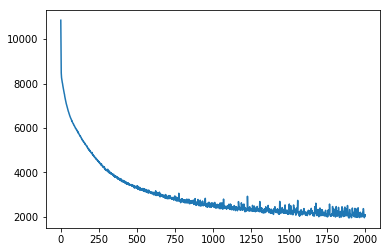

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:155: UserWarning: DEPRECATION: If x is a vector, Softmax will not automatically pad x anymore in next releases. If you need it, please do it manually. The vector case is gonna be supported soon and the output will be a vector.


stillgoing the story but a empty 
brushing a show you was was get 
she give from that is an winter evening 
that like if the course 


In [24]:
if __name__ == '__main__':
    train_poetry()
    generate_poetry()

Something that is very intersting to note about the above solution is that we started with a **randomly initialized** word embedding and ended up with a word embedding matrix that yielded a decent classification! In other words, this process allowed us to take words and convert them into vectors. Even if you have not gone through my posts on **Word2Vec** yet, this should still give a small taste as to how it may work! 